In [1]:
import pandas as pd

# Load the dataset
file_path = "hp23_hr.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# Convert the time column to datetime format and remove timezone information
df['time'] = pd.to_datetime(df['time']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Sort the dataframe by time in increasing order
df_sorted = df.sort_values(by='time')

# Display the first few rows of the sorted dataframe
print(df_sorted.head())

                  time data_type  value
0  2024-09-04 00:00:00        hr     84
1  2024-09-04 00:01:00        hr     85
2  2024-09-04 00:02:00        hr     85
3  2024-09-04 00:03:00        hr     89
4  2024-09-04 00:04:00        hr     82


In [2]:
import pandas as pd

# Load the steps dataset
file_path_steps = "hp23_steps.csv"  # Replace with your actual file path
df_steps = pd.read_csv(file_path_steps)

# Convert the time column to datetime format and remove timezone information
df_steps['time'] = pd.to_datetime(df_steps['time']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Sort the dataframe by time in increasing order
df_steps_sorted = df_steps.sort_values(by='time')

# Display the first few rows of the sorted dataframe
print(df_steps_sorted.head())

                  time data_type  value
0  2024-09-04 03:02:00     steps     13
1  2024-09-04 03:03:00     steps      5
2  2024-09-04 03:04:00     steps     28
3  2024-09-04 03:05:00     steps     15
4  2024-09-04 03:06:00     steps     25


In [3]:
# Load the blood pressure dataset
file_path_bp = "blood_pressure_readings_ID23_cleaned.csv"  # Replace with your actual file path
df_bp = pd.read_csv(file_path_bp)

# Select relevant columns
df_bp = df_bp[['datetime_local', 'systolic', 'diastolic']]

# Convert the datetime column to datetime format
df_bp['datetime_local'] = pd.to_datetime(df_bp['datetime_local'])

# Sort the dataframe by datetime in increasing order
df_bp_sorted = df_bp.sort_values(by='datetime_local')

# Add a binary classification column for BP spikes
df_bp_sorted['BP_spike'] = ((df_bp_sorted['systolic'] > 130) | (df_bp_sorted['diastolic'] > 80)).astype(int)

# Count the number of BP spikes and total records
total_records = len(df_bp_sorted)
bp_spike_count = df_bp_sorted['BP_spike'].sum()

# Print summary
print(f"Total records: {total_records}")
print(f"Number of BP spikes: {bp_spike_count}")

# Display the first few rows of the processed dataframe
print(df_bp_sorted.head())

Total records: 230
Number of BP spikes: 26
        datetime_local  systolic  diastolic  BP_spike
0  2024-09-03 08:51:14        83         54         0
1  2024-09-03 10:56:28        93         58         0
3  2024-09-03 12:31:43        99         63         0
2  2024-09-03 14:50:13       100         61         0
16 2024-09-03 15:48:06       106         61         0


In [5]:
# Load the stress data dataset
file_path_stress = "questionnaire_responses_ID23.csv"  # Replace with your actual file path
df_stress = pd.read_csv(file_path_stress)

# Select relevant columns
df_stress = df_stress[['local_created_at', 'stressLevel_value']]

# Convert the time column to datetime format
df_stress['local_created_at'] = pd.to_datetime(df_stress['local_created_at'])

# Sort the dataframe by time in increasing order
df_stress_sorted = df_stress.sort_values(by='local_created_at')

# Display the first few rows of the processed dataframe
print(df_stress_sorted.head())

     local_created_at  stressLevel_value
0 2024-09-03 08:58:00                  5
1 2024-09-03 19:01:00                  4
2 2024-09-04 05:41:00                  3
3 2024-09-04 07:56:00                  3
4 2024-09-04 09:12:00                  3


In [6]:
import pandas as pd
import numpy as np

# 📌 **Step 1: Load Datasets**
file_path_hr = "hp23_hr.csv"
file_path_steps = "hp23_steps.csv"
file_path_bp = "blood_pressure_readings_ID23_cleaned.csv"
file_path_stress = "questionnaire_responses_ID23.csv"

df_hr = pd.read_csv(file_path_hr)
df_steps = pd.read_csv(file_path_steps)
df_bp = pd.read_csv(file_path_bp)
df_stress = pd.read_csv(file_path_stress)

# 📌 **Step 2: Convert timestamps to uniform `datetime64[ns]`**
df_hr['time'] = pd.to_datetime(df_hr['time']).dt.tz_localize(None)
df_steps['time'] = pd.to_datetime(df_steps['time']).dt.tz_localize(None)
df_bp['datetime_local'] = pd.to_datetime(df_bp['datetime_local']).dt.tz_localize(None)
df_stress['local_created_at'] = pd.to_datetime(df_stress['local_created_at']).dt.tz_localize(None)

# 📌 **Step 3: Remove Data from `2024-10-23` for BP & Stress**
df_bp = df_bp[df_bp['datetime_local'].dt.date > pd.to_datetime("2024-09-03").date()]
df_stress = df_stress[df_stress['local_created_at'].dt.date > pd.to_datetime("2024-09-03").date()]

# 📌 **Step 4: Sort datasets by time**
df_hr_sorted = df_hr.sort_values(by='time')
df_steps_sorted = df_steps.sort_values(by='time')
df_bp_sorted = df_bp.sort_values(by='datetime_local')
df_stress_sorted = df_stress.sort_values(by='local_created_at')

# 📌 **Step 5: Add BP spike classification**
df_bp_sorted['BP_spike'] = ((df_bp_sorted['systolic'] > 130) | (df_bp_sorted['diastolic'] > 80)).astype(int)

# 📌 **Step 6: Merge HR & Steps Data Based on Nearest Timestamp**
df_biosignals = pd.merge_asof(df_hr_sorted, df_steps_sorted, on='time', direction='backward', suffixes=('_hr', '_steps'))

# 📌 **Step 7: Compute Rolling Window Statistics for HR & Steps**
df_biosignals.set_index('time', inplace=True)
time_windows = [5, 10, 30, 60]  # Define time windows (minutes)

for window in time_windows:
    window_str = f"{window}min"
    df_biosignals[f'hr_mean_{window_str}'] = df_biosignals['value_hr'].rolling(f"{window}min").mean()
    df_biosignals[f'hr_min_{window_str}'] = df_biosignals['value_hr'].rolling(f"{window}min").min()
    df_biosignals[f'hr_max_{window_str}'] = df_biosignals['value_hr'].rolling(f"{window}min").max()
    df_biosignals[f'hr_std_{window_str}'] = df_biosignals['value_hr'].rolling(f"{window}min").std()

    df_biosignals[f'steps_total_{window_str}'] = df_biosignals['value_steps'].rolling(f"{window}min").sum()
    df_biosignals[f'steps_mean_{window_str}'] = df_biosignals['value_steps'].rolling(f"{window}min").mean()
    df_biosignals[f'steps_min_{window_str}'] = df_biosignals['value_steps'].rolling(f"{window}min").min()
    df_biosignals[f'steps_max_{window_str}'] = df_biosignals['value_steps'].rolling(f"{window}min").max()
    df_biosignals[f'steps_std_{window_str}'] = df_biosignals['value_steps'].rolling(f"{window}min").std()
    df_biosignals[f'steps_diff_{window_str}'] = df_biosignals[f'steps_max_{window_str}'] - df_biosignals[f'steps_min_{window_str}']

# Reset index after rolling computation
df_biosignals.reset_index(inplace=True)

# 📌 **Step 8: Merge BP Data with HR & Steps Features**
df_merged = pd.merge_asof(df_bp_sorted, df_biosignals, left_on='datetime_local', right_on='time', direction='backward')

# 📌 **Step 9: Incorporate Stress Data (±15 minutes window)**
def extract_stress_features(bp_time, df_stress):
    start_time = bp_time - pd.Timedelta(minutes=15)
    end_time = bp_time + pd.Timedelta(minutes=15)
    stress_values = df_stress[(df_stress['local_created_at'] >= start_time) & (df_stress['local_created_at'] <= end_time)]['stressLevel_value']
    
    return pd.Series({
        'stress_mean': stress_values.mean(),
        'stress_min': stress_values.min(),
        'stress_max': stress_values.max(),
        'stress_std': stress_values.std()
    })

df_stress_features = df_bp_sorted['datetime_local'].apply(lambda x: extract_stress_features(x, df_stress_sorted))
df_merged = pd.concat([df_merged, df_stress_features], axis=1)

# 📌 **Step 10: Create Additional Engineered Features**
# ✅ Lagged Features
lag_features = ['stress_mean', 'BP_spike', 'hr_mean_5min', 'steps_total_10min']
for feature in lag_features:
    for lag in [1, 3, 5]:  
        df_merged[f'{feature}_lag_{lag}'] = df_merged[feature].shift(lag)

# ✅ Feature Interactions
df_merged['hr_steps_ratio'] = df_merged['hr_mean_5min'] / (df_merged['steps_total_10min'] + 1)
df_merged['stress_weighted_hr'] = df_merged['hr_mean_5min'] * df_merged['stress_mean']
df_merged['stress_steps_ratio'] = df_merged['stress_mean'] / (df_merged['steps_total_10min'] + 1)
df_merged['steps_hr_variability_ratio'] = df_merged['steps_std_10min'] / (df_merged['hr_std_10min'] + 1e-5)

# ✅ Rolling Aggregations
df_merged['hr_mean_rolling_3'] = df_merged['hr_mean_5min'].rolling(3).mean()
df_merged['steps_total_rolling_5'] = df_merged['steps_total_10min'].rolling(5).mean()
df_merged['hr_std_rolling_3'] = df_merged['hr_std_10min'].rolling(3).std()
df_merged['cumulative_stress_30min'] = df_merged['stress_mean'].rolling(3).sum()
df_merged['cumulative_steps_30min'] = df_merged['steps_total_10min'].rolling(3).sum()

# ✅ Contextual Features
df_merged['hour_of_day'] = df_merged['datetime_local'].dt.hour
df_merged['day_of_week'] = df_merged['datetime_local'].dt.dayofweek
df_merged['is_working_hours'] = df_merged['hour_of_day'].between(9, 17).astype(int)
df_merged['is_weekend'] = (df_merged['day_of_week'] >= 5).astype(int)

# ✅ Time Since Last BP Spike
df_merged['time_since_last_BP_spike'] = df_merged['datetime_local'].diff().dt.total_seconds() / 60
df_merged['time_since_last_BP_spike'] = df_merged['time_since_last_BP_spike'].ffill()

# 📌 **Step 11: Handle Missing Values**
df_merged.ffill(inplace=True)  
df_merged.bfill(inplace=True)  # Fixes rolling feature NaNs at the beginning

# 📌 **Step 12: Save Processed Dataset**
df_merged.to_csv("processed_bp_prediction_data.csv", index=False)
print("✅ Final dataset saved as 'processed_bp_prediction_data.csv'.")
print(df_merged.head())


✅ Final dataset saved as 'processed_bp_prediction_data.csv'.
       id  user_id    reading_id             datetime      datetime_local  \
0  1373.0     23.0  1.725464e+12  2024-09-04 15:38:25 2024-09-04 05:38:25   
1  1372.0     23.0  1.725469e+12  2024-09-04 16:52:13 2024-09-04 06:52:13   
2  1371.0     23.0  1.725472e+12  2024-09-04 17:54:41 2024-09-04 07:54:41   
3  1370.0     23.0  1.725476e+12  2024-09-04 19:01:11 2024-09-04 09:01:11   
4  1369.0     23.0  1.725480e+12  2024-09-04 20:01:13 2024-09-04 10:01:13   

   systolic  diastolic  pulse device_type           created_at  ...  \
0     101.0       63.0   81.0      BP8000  2024-09-04 22:48:10  ...   
1      87.0       60.0   83.0      BP8000  2024-09-04 22:48:10  ...   
2     100.0       68.0   84.0      BP8000  2024-09-04 22:48:10  ...   
3     111.0       66.0   75.0      BP8000  2024-09-04 22:48:10  ...   
4     109.0       63.0   86.0      BP8000  2024-09-04 22:48:10  ...   

   hr_mean_rolling_3 steps_total_rolling_5 hr_std

Trial 20 Complete [00h 02m 26s]
val_auc: 0.7620689868927002

Best val_auc So Far: 0.8758620619773865
Total elapsed time: 00h 45m 13s

🔹 Best LSTM hyperparameters:
{'lstm_units': 192, 'dropout_rate': 0.2, 'lstm_units_2': 80, 'attention_variant': 'multihead', 'dense_units': 32, 'dense_reg': 0.001, 'learning_rate': 0.0005, 'num_heads': 1, 'key_dim': 16}
2/2 [==============================] - 3s 39ms/step

🔹 Ensemble Weight Grid Search:
Alpha: 0.00, Beta: 1.00, AUROC: 0.876
Alpha: 0.10, Beta: 0.90, AUROC: 0.890
Alpha: 0.20, Beta: 0.80, AUROC: 0.883
Alpha: 0.30, Beta: 0.70, AUROC: 0.910
Alpha: 0.40, Beta: 0.60, AUROC: 0.928
Alpha: 0.50, Beta: 0.50, AUROC: 0.921
Alpha: 0.60, Beta: 0.40, AUROC: 0.917
Alpha: 0.70, Beta: 0.30, AUROC: 0.917
Alpha: 0.80, Beta: 0.20, AUROC: 0.900
Alpha: 0.90, Beta: 0.10, AUROC: 0.852
Alpha: 1.00, Beta: 0.00, AUROC: 0.769

🔹 Best Ensemble Weights: Alpha = 0.40, Beta = 0.60, AUROC = 0.928
Threshold: 0.00 | Sensitivity: 1.00 | Specificity: 0.00 | Youden Index: 0.00
T

Threshold: 0.98 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00
Threshold: 0.99 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00
Threshold: 1.00 | Sensitivity: 0.00 | Specificity: 1.00 | Youden Index: 0.00

🔹 Best Threshold in [0,1]: 0.62
🔹 Final Sensitivity (Recall): 1.000
🔹 Final Specificity: 0.897


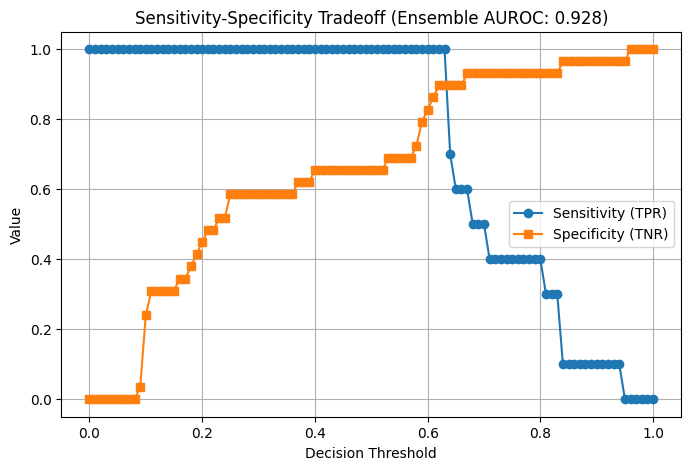

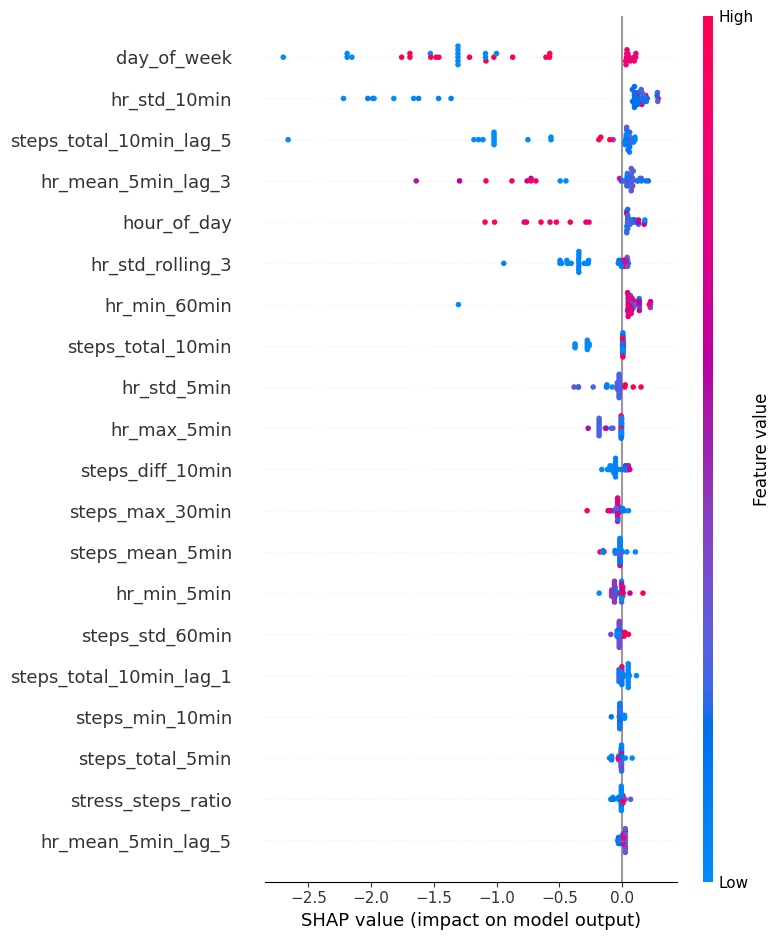

Total training time: 2794.91 seconds


In [9]:
import time
start_time = time.time()

import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import kerastuner as kt

#############################################
# Custom Attention Layers
#############################################
# 1. Custom (simple) Attention Layer (as before)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# 2. MultiHeadAttention Layer wrapped in a custom layer
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)
    def call(self, inputs):
        attn_output = self.mha(query=inputs, key=inputs, value=inputs)
        return tf.reduce_mean(attn_output, axis=1)

# 3. Self-Attention Layer using tf.keras.layers.Attention
class SelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SelfAttentionLayer, self).__init__(**kwargs)
        self.att = tf.keras.layers.Attention()
    def call(self, x):
        att_out = self.att([x, x])
        return tf.reduce_mean(att_out, axis=1)

# 4. Transformer Block as a custom layer with corrected dimensions
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.ff_dim = ff_dim
        self.rate = rate
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def build(self, input_shape):
        # Set embed_dim equal to the last dimension of the input
        self.embed_dim = input_shape[-1]
        self.ffn = Sequential([
            Dense(self.ff_dim, activation='relu'),
            Dense(self.embed_dim)
        ])
        super(TransformerBlock, self).build(input_shape)
    def call(self, inputs, training=False):
        attn_output = self.mha(query=inputs, key=inputs, value=inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

#############################################
# 1. Load Processed Dataset and Define Features
#############################################
df = pd.read_csv("processed_bp_prediction_data.csv")

features = [
    'hr_mean_5min', 'hr_min_5min', 'hr_max_5min', 'hr_std_5min',
    'steps_total_5min', 'steps_mean_5min', 'steps_min_5min', 'steps_max_5min', 'steps_std_5min', 'steps_diff_5min',
    'hr_mean_10min', 'hr_min_10min', 'hr_max_10min', 'hr_std_10min',
    'steps_total_10min', 'steps_mean_10min', 'steps_min_10min', 'steps_max_10min', 'steps_std_10min', 'steps_diff_10min',
    'hr_mean_30min', 'hr_min_30min', 'hr_max_30min', 'hr_std_30min',
    'steps_total_30min', 'steps_mean_30min', 'steps_min_30min', 'steps_max_30min', 'steps_std_30min', 'steps_diff_30min',
    'hr_mean_60min', 'hr_min_60min', 'hr_max_60min', 'hr_std_60min',
    'steps_total_60min', 'steps_mean_60min', 'steps_min_60min', 'steps_max_60min', 'steps_std_60min', 'steps_diff_60min',
    'stress_mean', 'stress_min', 'stress_max',
    'stress_mean_lag_1', 'stress_mean_lag_3', 'stress_mean_lag_5',
    'BP_spike_lag_1', 'BP_spike_lag_3', 'BP_spike_lag_5',
    'hr_mean_5min_lag_1', 'hr_mean_5min_lag_3', 'hr_mean_5min_lag_5',
    'steps_total_10min_lag_1', 'steps_total_10min_lag_3', 'steps_total_10min_lag_5',
    'hr_steps_ratio', 'stress_weighted_hr', 'stress_steps_ratio', 'steps_hr_variability_ratio',
    'hr_mean_rolling_3', 'steps_total_rolling_5', 'hr_std_rolling_3',
    'cumulative_stress_30min', 'cumulative_steps_30min',
    'hour_of_day', 'day_of_week', 'is_working_hours', 'is_weekend',
    'time_since_last_BP_spike'
]
target = "BP_spike"

df = df[["datetime_local"] + features + [target]]
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

df['datetime_local'] = pd.to_datetime(df['datetime_local'])
train_cutoff = df['datetime_local'].min() + pd.Timedelta(days=17)
train_data = df[df['datetime_local'] < train_cutoff]
test_data = df[df['datetime_local'] >= train_cutoff]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

print("🔹 BP Spike Counts Before Resampling:")
print(f"   - Training Set: {sum(y_train)} spikes ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"   - Test Set: {sum(y_test)} spikes ({sum(y_test)/len(y_test)*100:.2f}%)")

#############################################
# 2. Grid Search over ADASYN Sampling Strategy and XGBoost Hyperparameters
#############################################
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42))
])

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos
print(f"🔹 Computed scale_pos_weight: {scale_pos_weight:.2f}")

param_grid = {
    'adasyn__sampling_strategy': [0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 150, 200],
    'xgb__scale_pos_weight': [scale_pos_weight]
}

grid_search_pipeline = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search_pipeline.fit(X_train, y_train)

print("🔹 Best parameters from grid search (XGBoost pipeline):")
print(grid_search_pipeline.best_params_)

best_xgb_pipeline = grid_search_pipeline.best_estimator_

#############################################
# 3. Prepare Data and Hyperparameter Tuning for LSTM with Keras Tuner (Optimizing for AUROC)
#############################################
scaler_lstm = StandardScaler()
X_train_scaled_lstm = scaler_lstm.fit_transform(X_train)
X_test_scaled_lstm = scaler_lstm.transform(X_test)

best_sampling_strategy = grid_search_pipeline.best_params_['adasyn__sampling_strategy']
adasyn_best = ADASYN(sampling_strategy=best_sampling_strategy, random_state=42)
X_train_resampled_lstm, y_train_resampled_lstm = adasyn_best.fit_resample(X_train_scaled_lstm, y_train)

X_train_lstm = X_train_resampled_lstm.reshape((X_train_resampled_lstm.shape[0], X_train_resampled_lstm.shape[1], 1))
X_test_lstm = X_test_scaled_lstm.reshape((X_test_scaled_lstm.shape[0], X_test_scaled_lstm.shape[1], 1))

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_resampled_lstm), y=y_train_resampled_lstm)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"🔹 Class Weights for LSTM: {class_weight_dict}")

def build_model(hp):
    model = Sequential()
    # First layer: Bidirectional LSTM (return sequences)
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True),
                            input_shape=(X_train_lstm.shape[1], 1)))
    model.add(BatchNormalization())
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    # Second LSTM layer (return sequences for attention)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=16)
    model.add(LSTM(lstm_units_2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Attention variant selection: choose among 'custom', 'multihead', 'selfattention', 'transformer'
    att_variant = hp.Choice('attention_variant', ['custom', 'multihead', 'selfattention', 'transformer'])
    if att_variant == 'custom':
        model.add(AttentionLayer())
    elif att_variant == 'multihead':
        num_heads = hp.Int('num_heads', min_value=1, max_value=4, step=1)
        key_dim = hp.Int('key_dim', min_value=16, max_value=64, step=16)
        model.add(MultiHeadAttentionLayer(num_heads=num_heads, key_dim=key_dim))
    elif att_variant == 'selfattention':
        model.add(SelfAttentionLayer())
    else:  # transformer variant
        trans_num_heads = hp.Int('trans_num_heads', min_value=1, max_value=4, step=1)
        trans_key_dim = hp.Int('trans_key_dim', min_value=16, max_value=64, step=16)
        ff_dim = hp.Int('ff_dim', min_value=32, max_value=128, step=32)
        transformer_block = TransformerBlock(num_heads=trans_num_heads, key_dim=trans_key_dim, ff_dim=ff_dim, rate=dropout_rate)
        model.add(transformer_block)
        model.add(GlobalAveragePooling1D())
    
    # Additional Dense layer with L2 regularization
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    dense_reg = hp.Choice('dense_reg', values=[0.0, 0.001, 0.01, 0.1])
    model.add(Dense(dense_units, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(dense_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=20,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='bp_spike_prediction',
    overwrite=True
)

tuner.search(X_train_lstm, y_train_resampled_lstm,
             epochs=50,
             batch_size=32,
             validation_data=(X_test_lstm, y_test),
             class_weight=class_weight_dict)

best_lstm = tuner.get_best_models(num_models=1)[0]
print("🔹 Best LSTM hyperparameters:")
print(tuner.get_best_hyperparameters(num_trials=1)[0].values)

#############################################
# 4. Model Predictions and Ensemble Weight Grid Search
#############################################
y_pred_xgb = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_lstm = best_lstm.predict(X_test_lstm).flatten()

alphas = np.linspace(0, 1, 11)
best_ensemble_auc = 0
best_alpha, best_beta = None, None

print("\n🔹 Ensemble Weight Grid Search:")
for alpha in alphas:
    beta = 1 - alpha
    y_pred_final = (alpha * y_pred_xgb) + (beta * y_pred_lstm)
    auc = roc_auc_score(y_test, y_pred_final)
    print(f"Alpha: {alpha:.2f}, Beta: {beta:.2f}, AUROC: {auc:.3f}")
    if auc > best_ensemble_auc:
        best_ensemble_auc = auc
        best_alpha, best_beta = alpha, beta

print(f"\n🔹 Best Ensemble Weights: Alpha = {best_alpha:.2f}, Beta = {best_beta:.2f}, AUROC = {best_ensemble_auc:.3f}")

#############################################
# 5. Grid Search for Optimal Threshold in the Range 0 to 1 (step = 0.01)
#############################################
thresholds = np.arange(0, 1.01, 0.01)
best_threshold = None
best_youden = -1
final_sens = final_spec = None

for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    youden_index = sensitivity + specificity - 1
    print(f"Threshold: {threshold:.2f} | Sensitivity: {sensitivity:.2f} | Specificity: {specificity:.2f} | Youden Index: {youden_index:.2f}")
    if youden_index > best_youden:
        best_youden = youden_index
        best_threshold = threshold
        final_sens = sensitivity
        final_spec = specificity

print(f"\n🔹 Best Threshold in [0,1]: {best_threshold:.2f}")
print(f"🔹 Final Sensitivity (Recall): {final_sens:.3f}")
print(f"🔹 Final Specificity: {final_spec:.3f}")

#############################################
# 6. Plot Sensitivity-Specificity Tradeoff for Thresholds from 0 to 1
#############################################
sens_list, spec_list = [], []
for threshold in thresholds:
    y_pred_binary = ((best_alpha * y_pred_xgb) + (best_beta * y_pred_lstm) >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sens_list.append(sensitivity)
    spec_list.append(specificity)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, sens_list, label="Sensitivity (TPR)", marker='o')
plt.plot(thresholds, spec_list, label="Specificity (TNR)", marker='s')
plt.xlabel("Decision Threshold")
plt.ylabel("Value")
plt.title(f"Sensitivity-Specificity Tradeoff (Ensemble AUROC: {best_ensemble_auc:.3f})")
plt.legend()
plt.grid()
plt.show()

#############################################
# 7. SHAP Analysis for XGBoost Model
#############################################
scaler_xgb = best_xgb_pipeline.named_steps['scaler']
xgb_model = best_xgb_pipeline.named_steps['xgb']
X_test_scaled_for_shap = scaler_xgb.transform(X_test)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled_for_shap)
shap.summary_plot(shap_values, X_test, feature_names=features)

#############################################
# 8. Print Total Training Time
#############################################
end_time = time.time()
print("Total training time: {:.2f} seconds".format(end_time - start_time))


In [10]:
print("🔹 BP Spike Counts Before Resampling:")
print(f"   - Training Set: {sum(y_train)} spikes out of {len(y_train)} samples ({sum(y_train)/len(y_train)*100:.2f}%)")
print(f"   - Test Set: {sum(y_test)} spikes out of {len(y_test)} samples ({sum(y_test)/len(y_test)*100:.2f}%)")

🔹 BP Spike Counts Before Resampling:
   - Training Set: 16.0 spikes out of 191 samples (8.38%)
   - Test Set: 10.0 spikes out of 39 samples (25.64%)
